In [3]:
pip install scikit-learn numpy matplotlib

Loading MNIST dataset...
Total samples (0s and 1s): 14780
Training samples: 100
Test samples: 200

--- Classical SVM ---
Classical SVM Accuracy: 0.9900
Training time: 0.00 seconds

--- Quantum SVM (Simulated) ---
Computing quantum kernel matrices...
QSVM Accuracy: 0.7150
Training time: 3.33 seconds

RESULTS SUMMARY
Model                Accuracy        Time           
--------------------------------------------------
Classical SVM        99.0%           0.00s
Quantum SVM          71.5%           3.33s
--------------------------------------------------
Accuracy Gap: 27.5%


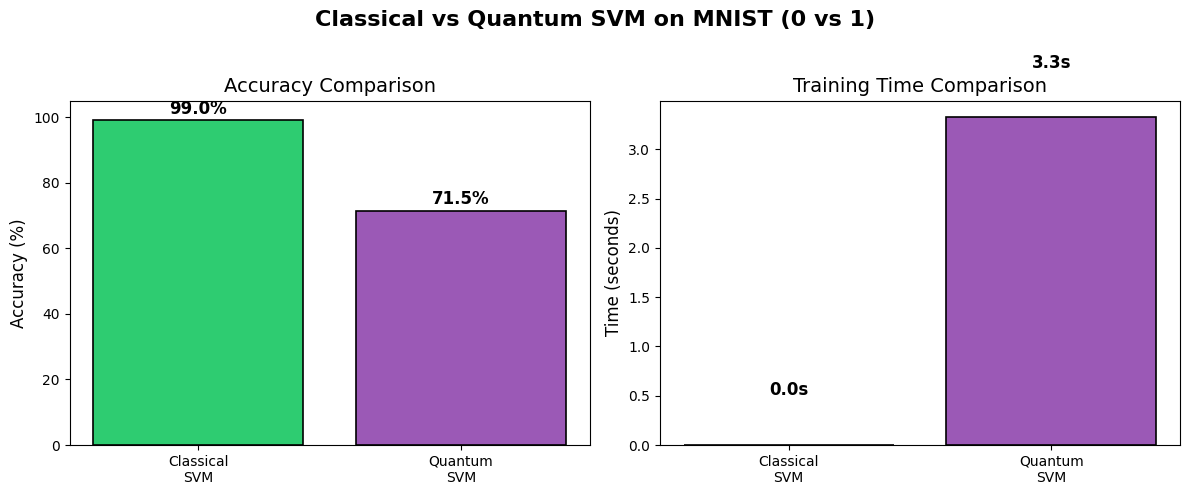


✅ Chart saved as 'mnist_results_comparison.png'


In [28]:
###########################################
# Quantum vs Classical ML Comparison
# Dataset: MNIST (digits 0 vs 1)
# Models: SVM vs Manual QSVM
###########################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

###########################################
# 1. LOAD AND PREPARE MNIST DATA
###########################################

print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Filter only digits 0 and 1
mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

print(f"Total samples (0s and 1s): {len(y)}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2 features for quantum encoding
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Use smaller training set for speed (100 samples)
X_train = X_train_full[:100]
y_train = y_train_full[:100]

# Use smaller test set too (200 samples)
X_test = X_test[:200]
y_test = y_test[:200]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

###########################################
# 2. CLASSICAL SVM
###########################################

print("\n--- Classical SVM ---")
start_time = time.time()

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

svm_time = time.time() - start_time
print(f"Classical SVM Accuracy: {svm_acc:.4f}")
print(f"Training time: {svm_time:.2f} seconds")

###########################################
# 3. MANUAL QSVM (NumPy Simulation)
###########################################

print("\n--- Quantum SVM (Simulated) ---")
start_time = time.time()

# RY rotation gate
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2), np.cos(theta/2)]
    ])

# Create quantum state from features
def feature_state(x):
    state = np.array([1.0])
    for feature in x:
        ry = RY(feature)
        qubit_state = ry @ np.array([1.0, 0.0])
        state = np.kron(state, qubit_state)
    return state / np.linalg.norm(state)

# Compute quantum kernel matrix
def compute_quantum_kernel(X1, X2):
    n1, n2 = len(X1), len(X2)
    kernel = np.zeros((n1, n2))
    for i in range(n1):
        psi_i = feature_state(X1[i])
        for j in range(n2):
            psi_j = feature_state(X2[j])
            # Fidelity-based kernel
            kernel[i, j] = np.abs(np.vdot(psi_i, psi_j)) ** 2
    return kernel

# Compute kernels
print("Computing quantum kernel matrices...")
K_train = compute_quantum_kernel(X_train, X_train)
K_test = compute_quantum_kernel(X_test, X_train)

# Train QSVM
qsvm = SVC(kernel='precomputed')
qsvm.fit(K_train, y_train)
qsvm_pred = qsvm.predict(K_test)
qsvm_acc = accuracy_score(y_test, qsvm_pred)

qsvm_time = time.time() - start_time
print(f"QSVM Accuracy: {qsvm_acc:.4f}")
print(f"Training time: {qsvm_time:.2f} seconds")

###########################################
# 4. RESULTS COMPARISON
###########################################

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"{'Model':<20} {'Accuracy':<15} {'Time':<15}")
print("-"*50)
print(f"{'Classical SVM':<20} {svm_acc*100:.1f}%{'':<10} {svm_time:.2f}s")
print(f"{'Quantum SVM':<20} {qsvm_acc*100:.1f}%{'':<10} {qsvm_time:.2f}s")
print("-"*50)
print(f"Accuracy Gap: {(svm_acc - qsvm_acc)*100:.1f}%")
print("="*50)

###########################################
# 5. CREATE VISUALIZATION
###########################################

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Accuracy Comparison
models = ['Classical\nSVM', 'Quantum\nSVM']
accuracies = [svm_acc * 100, qsvm_acc * 100]
colors = ['#2ecc71', '#9b59b6']

axes[0].bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14)
axes[0].set_ylim(0, 105)

for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 2, f'{acc:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Plot 2: Training Time Comparison
times = [svm_time, qsvm_time]
axes[1].bar(models, times, color=colors, edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14)

for i, t in enumerate(times):
    axes[1].text(i, t + 0.5, f'{t:.1f}s', ha='center', fontsize=12, fontweight='bold')

plt.suptitle('Classical vs Quantum SVM on MNIST (0 vs 1)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('mnist_results_comparison.png', dpi=150)
plt.show()

print("\n✅ Chart saved as 'mnist_results_comparison.png'")

CIRQ

In [30]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 68.8 MB/s eta 0:00:00


Loading MNIST dataset...
Training samples: 100, Test samples: 200

--- Classical SVM ---
Classical SVM Accuracy: 0.9900
Training time: 0.02 seconds

--- Quantum Kernel SVM (Cirq) ---
Computing quantum kernel matrices (training)...
Computing quantum kernel matrices (testing)...
Quantum SVM Accuracy: 0.8800
Training time: 50.27 seconds

RESULTS SUMMARY
Model                Accuracy        Time           
--------------------------------------------------
Classical SVM        99.0%           0.02s
Quantum SVM          88.0%           50.27s
--------------------------------------------------
Accuracy Gap: 11.0%


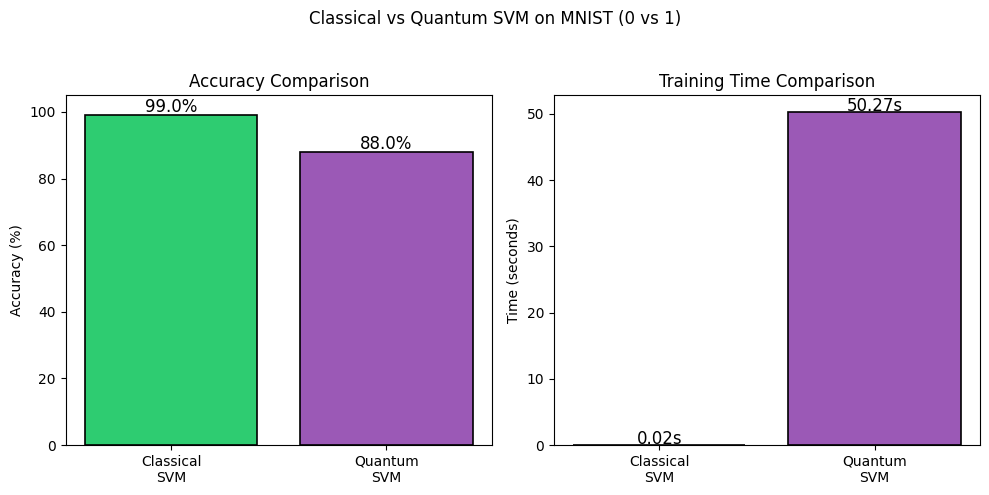

In [32]:
import cirq
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt

# --- 1. Load and prepare MNIST (digits 0 vs 1) ---
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2 features with PCA for quantum encoding
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Use fewer samples for speed
X_train = X_train_full[:100]
y_train = y_train_full[:100]

X_test = X_test[:200]
y_test = y_test[:200]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# --- 2. Define Cirq Quantum Feature Map (Quantum Kernel) ---

def create_feature_map_circuit(x):
    """Creates a parameterized quantum feature map circuit.
    Args:
        x: Array of features in [-1, 1] range (2 features expected)
    Returns:
        cirq.Circuit
    """

    # Normalize input features to [0, pi]
    scaled_x = (x - x.min()) / (x.max() - x.min() + 1e-8) * np.pi

    qubits = [cirq.GridQubit(0, i) for i in range(len(x))]
    circuit = cirq.Circuit()

    for i, qubit in enumerate(qubits):
        # Encode feature with Ry rotation
        circuit.append(cirq.ry(scaled_x[i])(qubit))

    # Entangling layer: CZ gates between qubits
    if len(qubits) > 1:
        for i in range(len(qubits) - 1):
            circuit.append(cirq.CZ(qubits[i], qubits[i+1]))

    return circuit, qubits

# --- 3. Quantum kernel function ---

simulator = cirq.Simulator()

def quantum_kernel(x1, x2):
    """Compute the quantum kernel (fidelity)^2 between two inputs"""
    circuit1, qubits = create_feature_map_circuit(x1)
    circuit2, _ = create_feature_map_circuit(x2)

    # Prepare psi_1† psi_2 by appending inverse of circuit1 then circuit2
    full_circuit = cirq.Circuit()
    # Fix: Use cirq.inverse() instead of circuit.inverse()
    full_circuit.append(cirq.inverse(circuit1))
    full_circuit.append(circuit2)

    # Initialize qubits in |0..0> state, simulate full circuit
    result = simulator.simulate(full_circuit)

    # Fidelity = |<0| full_circuit |0>|^2 = probability amplitude squared of |0...0> in final state
    # amplitude of initial state = result.final_state_vector[0]
    fidelity = np.abs(result.final_state_vector[0]) ** 2
    return fidelity

def compute_kernel_matrix(X1, X2):
    """Compute quantum kernel matrix for datasets X1 and X2"""
    n1 = len(X1)
    n2 = len(X2)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = quantum_kernel(X1[i], X2[j])
    return K

# --- 4. Classical SVM baseline ---
print("\n--- Classical SVM ---")
start_time = time.time()

svm = SVC(kernel='rbf')

svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

svm_time = time.time() - start_time
print(f"Classical SVM Accuracy: {svm_acc:.4f}")
print(f"Training time: {svm_time:.2f} seconds")

# --- 5. Quantum Kernel SVM ---
print("\n--- Quantum Kernel SVM (Cirq) ---")
start_time = time.time()

print("Computing quantum kernel matrices (training)...")
K_train = compute_kernel_matrix(X_train, X_train)

print("Computing quantum kernel matrices (testing)...")
K_test = compute_kernel_matrix(X_test, X_train)

qsvm = SVC(kernel='precomputed')
qsvm.fit(K_train, y_train)
qsvm_pred = qsvm.predict(K_test)
qsvm_acc = accuracy_score(y_test, qsvm_pred)

qsvm_time = time.time() - start_time
print(f"Quantum SVM Accuracy: {qsvm_acc:.4f}")
print(f"Training time: {qsvm_time:.2f} seconds")

# --- 6. Results Summary and Visualization ---
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"{'Model':<20} {'Accuracy':<15} {'Time':<15}")
print("-"*50)
print(f"{'Classical SVM':<20} {svm_acc*100:.1f}%{'':<10} {svm_time:.2f}s")
print(f"{'Quantum SVM':<20} {qsvm_acc*100:.1f}%{'':<10} {qsvm_time:.2f}s")
print("-"*50)
print(f"Accuracy Gap: {(svm_acc - qsvm_acc)*100:.1f}%")
print("="*50)

models = ['Classical\nSVM', 'Quantum\nSVM']
accuracies = [svm_acc * 100, qsvm_acc * 100]
colors = ['#2ecc71', '#9b59b6']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)
plt.ylim(0, 105)
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 1, f'{acc:.1f}%', ha='center', fontsize=12)

times = [svm_time, qsvm_time]

plt.subplot(1, 2, 2)
bars = plt.bar(models, times, color=colors, edgecolor='black', linewidth=1.2)
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison')
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, t + 0.1, f'{t:.2f}s', ha='center', fontsize=12)

plt.suptitle('Classical vs Quantum SVM on MNIST (0 vs 1)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

QISKIT

Loading MNIST dataset...
Training samples: 100, Test samples: 200

--- Classical SVM ---
Classical SVM Accuracy: 0.9900
Training time: 0.00 seconds

--- Quantum Kernel SVM (Qiskit) ---
Computing quantum kernel matrix for training data...
Computing quantum kernel matrix for test data...
QSVM Accuracy: 0.4500
Training time: 1057.90 seconds

RESULTS SUMMARY
Model                Accuracy        Time           
--------------------------------------------------
Classical SVM        99.0%           0.00s
Quantum SVM          45.0%           1057.90s
--------------------------------------------------
Accuracy Gap: 54.0%


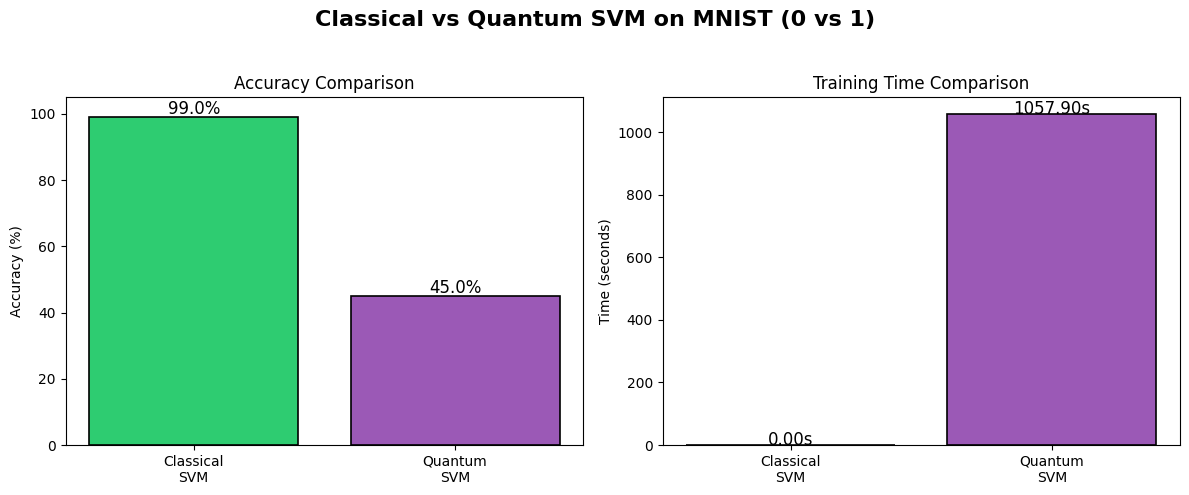

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# Updated Qiskit imports for modern versions
# Use SamplerV2 to satisfy BaseSamplerV2 requirement of ComputeUncompute
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import zz_feature_map

# --- 1. Load and prepare MNIST (digits 0 vs 1) ---
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2 features with PCA (quantum encoding dimension)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Use smaller subsets for speed
X_train = X_train_full[:100]
y_train = y_train_full[:100]

X_test = X_test[:200]
y_test = y_test[:200]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# --- 2. Classical SVM baseline ---
print("\n--- Classical SVM ---")
start_time = time.time()

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

svm_time = time.time() - start_time
print(f"Classical SVM Accuracy: {svm_acc:.4f}")
print(f"Training time: {svm_time:.2f} seconds")

# --- 3. Quantum Kernel SVM with Qiskit ---
print("\n--- Quantum Kernel SVM (Qiskit) ---")

# Define quantum feature map (using function instead of deprecated class)
feature_map = zz_feature_map(feature_dimension=2, reps=2, entanglement='linear')

# Setup FidelityQuantumKernel with AerSampler (SamplerV2)
# ComputeUncompute requires a SamplerV2
sampler = AerSampler()
fidelity = ComputeUncompute(sampler=sampler)
qkernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

start_time = time.time()

# Compute kernel matrices
print("Computing quantum kernel matrix for training data...")
K_train = qkernel.evaluate(X_train)

print("Computing quantum kernel matrix for test data...")
K_test = qkernel.evaluate(X_test, X_train)

# Train SVM with precomputed quantum kernel
qsvm = SVC(kernel='precomputed')
qsvm.fit(K_train, y_train)
qsvm_pred = qsvm.predict(K_test)
qsvm_acc = accuracy_score(y_test, qsvm_pred)

qsvm_time = time.time() - start_time
print(f"QSVM Accuracy: {qsvm_acc:.4f}")
print(f"Training time: {qsvm_time:.2f} seconds")

# --- 4. Results Comparison and Visualization ---
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"{'Model':<20} {'Accuracy':<15} {'Time':<15}")
print("-"*50)
print(f"{'Classical SVM':<20} {svm_acc*100:.1f}%{'':<10} {svm_time:.2f}s")
print(f"{'Quantum SVM':<20} {qsvm_acc*100:.1f}%{'':<10} {qsvm_time:.2f}s")
print("-"*50)
print(f"Accuracy Gap: {(svm_acc - qsvm_acc)*100:.1f}%")
print("="*50)

models = ['Classical\nSVM', 'Quantum\nSVM']
accuracies = [svm_acc * 100, qsvm_acc * 100]
colors = ['#2ecc71', '#9b59b6']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)
plt.ylim(0, 105)
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 1, f'{acc:.1f}%', ha='center', fontsize=12)

times = [svm_time, qsvm_time]

plt.subplot(1, 2, 2)
bars = plt.bar(models, times, color=colors, edgecolor='black', linewidth=1.2)
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison')
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, t + 0.1, f'{t:.2f}s', ha='center', fontsize=12)

plt.suptitle('Classical vs Quantum SVM on MNIST (0 vs 1)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

PENNYLANE

Loading MNIST dataset...
Training samples: 100
Test samples: 200

--- Classical SVM ---
Classical SVM Accuracy: 0.9900
Training time: 0.00 seconds

--- Quantum Kernel SVM (PennyLane) ---
Computing training kernel matrix...
Computing test kernel matrix...
Quantum SVM Accuracy: 0.7150
Training time: 63.97 seconds

RESULTS SUMMARY
Model                Accuracy        Time           
--------------------------------------------------
Classical SVM        99.0%           0.00s
Quantum SVM          71.5%           63.97s
--------------------------------------------------
Accuracy Gap: 27.5%


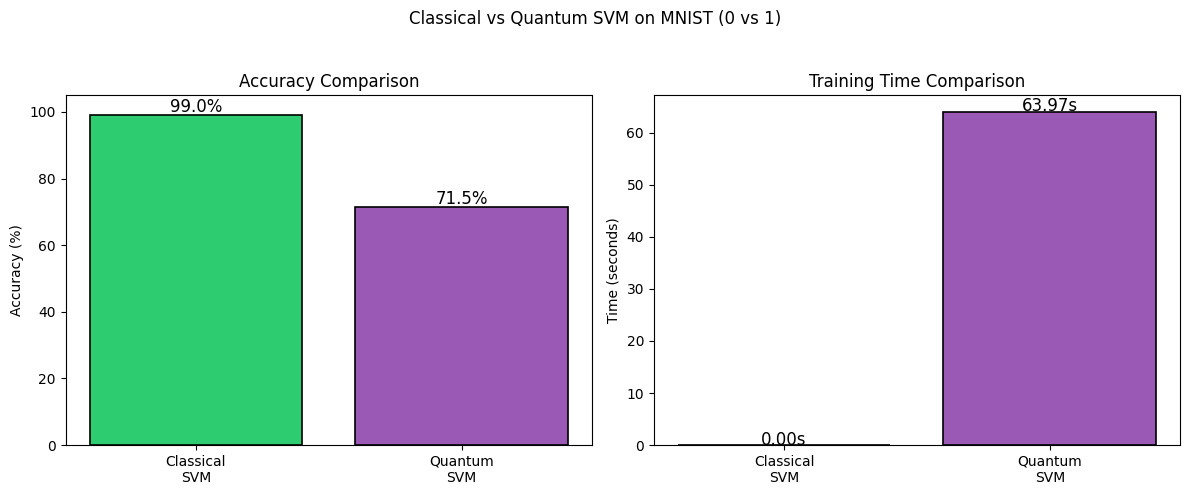

In [39]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt

# 1. LOAD AND PREPARE MNIST DATA
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2 features for quantum encoding
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Use smaller sets for speed
X_train = X_train_full[:100]
y_train = y_train_full[:100]
X_test = X_test[:200]
y_test = y_test[:200]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# 2. CLASSICAL SVM BASELINE
print("\n--- Classical SVM ---")
start_time = time.time()
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
svm_time = time.time() - start_time
print(f"Classical SVM Accuracy: {svm_acc:.4f}")
print(f"Training time: {svm_time:.2f} seconds")

# 3. PENNYLANE QUANTUM KERNEL SETUP

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum feature map circuit
def feature_map(x, y=None):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

@qml.qnode(dev)
def circuit(x, y=None):
    feature_map(x)
    qml.adjoint(feature_map)(y)
    return qml.probs(wires=range(n_qubits))  # Return full probs, index later

# Quantum kernel function
def quantum_kernel(x1, x2):
    # Index [0] corresponds to probability of state |0...0>
    return circuit(x1, x2)[0]

# Compute kernel matrix efficiently
def kernel_matrix(X1, X2):
    n1 = len(X1)
    n2 = len(X2)
    kmat = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            kmat[i, j] = quantum_kernel(X1[i], X2[j])
    return kmat

# Compute kernel matrices and train QSVM
print("\n--- Quantum Kernel SVM (PennyLane) ---")
start_time = time.time()

print("Computing training kernel matrix...")
K_train = kernel_matrix(X_train, X_train)
print("Computing test kernel matrix...")
K_test = kernel_matrix(X_test, X_train)

qsvm = SVC(kernel='precomputed')
qsvm.fit(K_train, y_train)
qsvm_pred = qsvm.predict(K_test)
qsvm_acc = accuracy_score(y_test, qsvm_pred)
qsvm_time = time.time() - start_time

print(f"Quantum SVM Accuracy: {qsvm_acc:.4f}")
print(f"Training time: {qsvm_time:.2f} seconds")

# 4. RESULTS VISUALIZATION
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"{'Model':<20} {'Accuracy':<15} {'Time':<15}")
print("-"*50)
print(f"{'Classical SVM':<20} {svm_acc*100:.1f}%{'':<10} {svm_time:.2f}s")
print(f"{'Quantum SVM':<20} {qsvm_acc*100:.1f}%{'':<10} {qsvm_time:.2f}s")
print("-"*50)
print(f"Accuracy Gap: {(svm_acc - qsvm_acc)*100:.1f}%")
print("="*50)

models = ['Classical\nSVM', 'Quantum\nSVM']
accuracies = [svm_acc * 100, qsvm_acc * 100]
colors = ['#2ecc71', '#9b59b6']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)
plt.ylim(0, 105)
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 1, f'{acc:.1f}%', ha='center', fontsize=12)

times = [svm_time, qsvm_time]
plt.subplot(1, 2, 2)
bars = plt.bar(models, times, color=colors, edgecolor='black', linewidth=1.2)
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison')
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, t + 0.1, f'{t:.2f}s', ha='center', fontsize=12)

plt.suptitle('Classical vs Quantum SVM on MNIST (0 vs 1)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()